# Person Counting System using YoloV8 and OpenVINO™

In this project, I utlized YOLOV8 Object Counting class to develop a real-time people counting system using the YOLOv8 object detection model, optimized for Intel's OpenVINO toolkit to enhance inferencing speed. This system effectively monitors the number of individuals entering and exiting a room, leveraging the optimized YOLOv8 model for accurate people detection under varied conditions.

By utilizing the OpenVINO runtime on Intel hardware, the system achieves significant improvements in processing speed, making it ideal for applications requiring real-time data, such as occupancy management and traffic flow control in public spaces and commercial settings.

> **NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server, the webcam will not work. However, you can still do inference on a video.


#### Table of contents:

- [Install pre-requisites](#Install-pre-requisites)
- [Download Model](#Download-Model)
- [Inference function](#Inference-function)
- [Run live demo](#Run-live-demo)
- [Select inference device](#Select-inference-device) 


## Install pre-requisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
!pip install "openvino>=2024.0.0" "ultralytics==8.2.18" "torch>=2.1" "ipywidgets==7.7.1"

## Download Model
Download and convert YoloV8 to OpenVINO Intermediate Representation

[back to top ⬆️](#Table-of-contents:)

In [2]:
from pathlib import Path
from ultralytics import YOLO

models_dir = Path("./models")
models_dir.mkdir(exist_ok=True)

DET_MODEL_NAME = "yolov8n"

det_model = YOLO(models_dir / f"{DET_MODEL_NAME}.pt")
label_map = det_model.model.names

# Need to make en empty call to initialize the model
res = det_model()
det_model_path = models_dir / f"{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml"
if not det_model_path.exists():
    det_model.export(format="openvino", dynamic=True, half=True)


WARNING ⚠️ 'source' is missing. Using 'source=/home/antonio/antonio/openvino_notebooks/openvino_env/lib/python3.10/site-packages/ultralytics/assets'.

image 1/2 /home/antonio/antonio/openvino_notebooks/openvino_env/lib/python3.10/site-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 48.3ms
image 2/2 /home/antonio/antonio/openvino_notebooks/openvino_env/lib/python3.10/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 33.2ms
Speed: 1.2ms preprocess, 40.8ms inference, 137.8ms postprocess per image at shape (1, 3, 384, 640)


/home/antonio/antonio/openvino_notebooks/openvino_env/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Inference function
[back to top ⬆️](#Table-of-contents:)

In [3]:
from ultralytics import YOLO, solutions
import cv2
import time
import collections
import numpy as np
from IPython import display
import torch
import openvino as ov
import ipywidgets as widgets

def run_inference(source,device):
    core = ov.Core()

    det_ov_model = core.read_model(det_model_path)
    ov_config = {} 

    if device.value != "CPU":
        det_ov_model.reshape({0: [1, 3, 640, 640]})
    if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(det_ov_model, device.value, ov_config)
    
    def infer(*args):
        result = compiled_model(args)
        return torch.from_numpy(result[0])
        
    # Use openVINO as inference engine 
    det_model.predictor.inference = infer
    det_model.predictor.model.pt = False
    
    try:
        cap = cv2.VideoCapture(source)
        assert cap.isOpened(), "Error reading video file"
        
        line_points = [(0, 300), (1080, 300)]   # line or region points       
        classes_to_count = [0]  # person is class 0 in the COCO dataset
        
        # Init Object Counter
        counter = solutions.ObjectCounter(
            view_img=False,                          
            reg_pts=line_points,
            classes_names=det_model.names,
            draw_tracks=True,
            line_thickness=2,
            view_in_counts=False,
            view_out_counts=False 
        )        
        # Processing time
        processing_times = collections.deque(maxlen=200) 
        
        while cap.isOpened():
            success, frame = cap.read()            
            if not success:
                print("Video frame is empty or video processing has been successfully completed.")
                break
        
            start_time = time.time()
            tracks = det_model.track(
                frame, persist=True, show=False,
                classes=classes_to_count,verbose=False
            )
            frame = counter.start_counting(frame, tracks)
            stop_time = time.time()
        
            processing_times.append(stop_time - start_time)
        
            # Mean processing time [ms].
            _, f_width = frame.shape[:2]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=2,
                lineType=cv2.LINE_AA,
            )
    
            # Get the counts. Counts are getting as 'OUT'
            # Modify this logic accordingly
            counts = counter.out_counts
            
            # Define the text to display
            text = f"Count: {counts}"
            fontFace = cv2.FONT_HERSHEY_COMPLEX
            fontScale = 0.75  # Adjust scale as needed
            thickness = 2
            
            # Calculate the size of the text box
            (text_width, text_height), _ = cv2.getTextSize(text, fontFace, fontScale, thickness)
            
            # Define the upper right corner for the text
            top_right_corner = (frame.shape[1] - text_width - 20, 40)                     
            # Draw the count of "OUT" on the frame
            cv2.putText(
                img=frame,
                text=text,
                org=(top_right_corner[0], top_right_corner[1]),
                fontFace=fontFace,
                fontScale=fontScale,
                color=(0, 0, 255),
                thickness=thickness,
                lineType=cv2.LINE_AA,
            )
        
            # Show the frame
            _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
            # Create an IPython image.
            i = display.Image(data=encoded_img)
            # Display the image in this notebook.
            display.clear_output(wait=True)
            display.display(i)
    except KeyboardInterrupt:
        print("Interrupted")
    
    cap.release()
    cv2.destroyAllWindows()

## Run live demo
[back to top ⬆️](#Table-of-contents:)

In [4]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = "https://github.com/intel-iot-devkit/sample-videos/raw/master/people-detection.mp4"

> **NOTE**: make sure to restart kernel and rull all cells when switching between video and webcam to avoid any errors.

## Select inference device
[back to top ⬆️](#Table-of-contents:)

In [8]:
core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

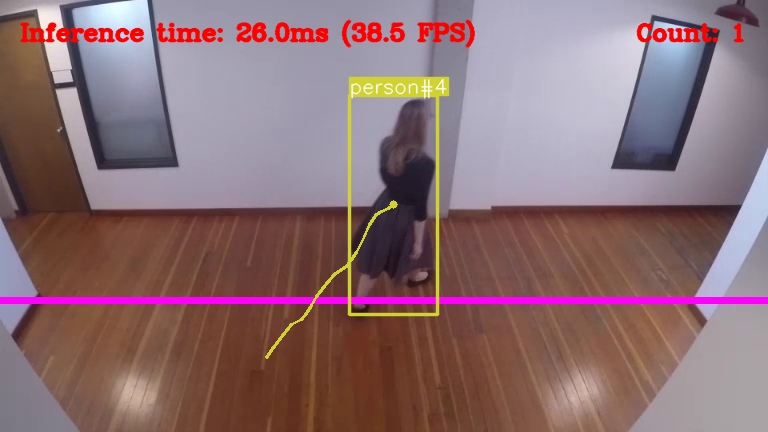

Interrupted


In [9]:
run_inference(
    source=VIDEO_SOURCE,    
    device=device,
)